# Day 55: 序列预测任务详解

在学习RNN及其变体之前，我们需要深入理解序列任务的本质。本节将系统介绍：
- 什么是序列预测
- 如何构建序列数据的x-y对
- 单步预测与多步预测的区别
- 时序任务的实战演练

---
## 一、序列预测任务介绍

### 1.1 什么是序列预测？

**传统结构化数据 vs 序列数据**

| 特性 | 结构化数据 | 序列数据 |
|------|-----------|----------|
| 样本关系 | 独立无关 | 存在先后顺序 |
| 顺序影响 | 调换顺序不影响训练 | 顺序至关重要 |
| 典型任务 | 分类、回归 | 预测下一步的值 |

**常见序列预测场景：**
- 📈 股票价格预测：用过去30天价格预测第31天
- 🚲 单车需求预测：用前60天数据预测后20天销量
- 📝 文本生成：预测下一个单词

### 1.2 序列预测的x-y对构建

**核心方法：滑动窗口（Sliding Window）**

将原始序列转化为监督学习所需的x-y标签对。

**示例：**
- 原始数据：`data = [10, 20, 30, 40, 50, 60, 70, 80, 90]`
- 序列长度：`seq_length = 3`

```
滑动窗口过程:
[10, 20, 30] → 40
   [20, 30, 40] → 50
      [30, 40, 50] → 60
         [40, 50, 60] → 70
            [50, 60, 70] → 80
               [60, 70, 80] → 90
```

**生成的数据对：**
```python
X = [[10, 20, 30], [20, 30, 40], [30, 40, 50], 
     [40, 50, 60], [50, 60, 70], [60, 70, 80]]
y = [40, 50, 60, 70, 80, 90]
```

**注意：** 样本数 = `len(data) - seq_length` = 9 - 3 = 6

### 1.3 序列预测的标准输入格式

标准序列数据张量具有三个维度：**[批量大小, 序列长度, 特征维度]**

| 维度 | 含义 | 说明 |
|------|------|------|
| Batch Size | 批量大小 | 一次喂给模型的样本数量 |
| Sequence Length | 序列长度 | 每个样本包含的时间步数 |
| Feature Dimension | 特征维度 | 每个时间步的特征数量 |

---
## 二、基础概念

### 2.1 环境准备

In [2]:
# ==================== 导入必要的库 ====================
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# ==================== 中文显示设置 ====================
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文
plt.rcParams['axes.unicode_minus'] = False     # 显示负号

# ==================== 忽略警告 ====================
import warnings
warnings.filterwarnings("ignore")

In [3]:
# ==================== 设置随机种子函数 ====================
def set_seed(seed=42, deterministic=True):
    """
    设置全局随机种子，确保实验可重复性
    
    参数:
        seed: 随机种子值，默认为42
        deterministic: 是否启用确定性模式，默认为True
    """
    # Python随机种子
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)  # 确保哈希函数随机性一致
    
    # NumPy随机种子
    np.random.seed(seed)
    
    # PyTorch随机种子
    torch.manual_seed(seed)           # CPU
    torch.cuda.manual_seed(seed)      # 单GPU
    torch.cuda.manual_seed_all(seed)  # 多GPU
    
    # cuDNN确定性配置
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# 设置随机种子
set_seed(42)
print("随机种子设置完成！")

随机种子设置完成！


### 2.2 数据生成

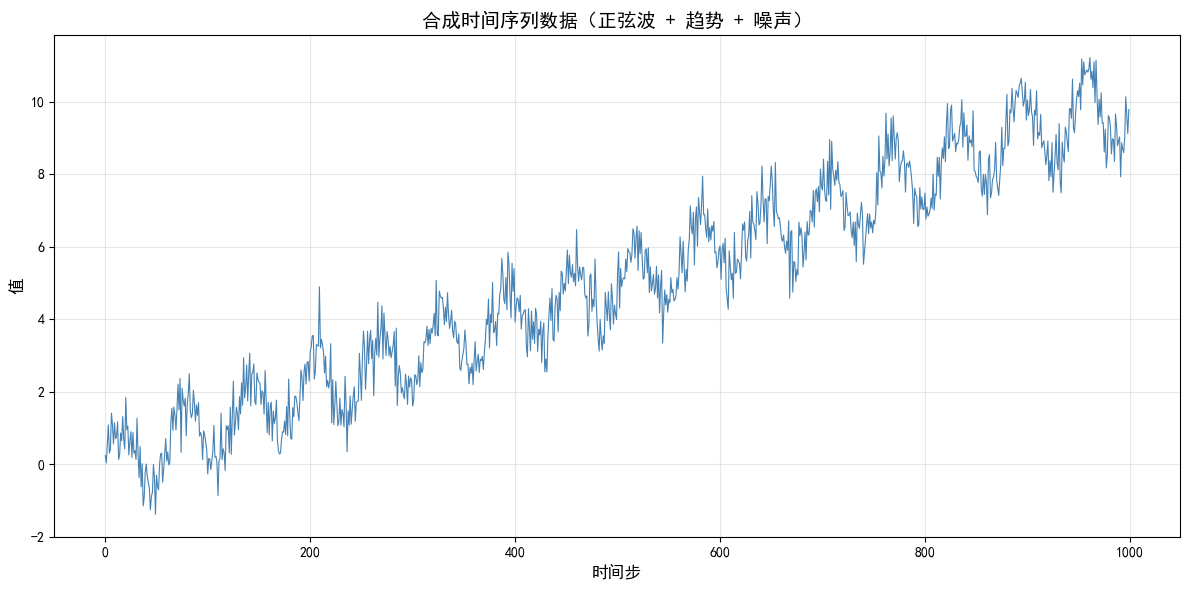

数据总长度: 1000


In [4]:
# ==================== 生成合成时间序列数据 ====================
# 在0到100之间生成1000个均匀分布的点
x = np.linspace(0, 100, 1000)

# 构造时间序列：正弦波 + 线性趋势 + 随机噪声
y = np.sin(x) + 0.1 * x + np.random.normal(0, 0.5, 1000)

# ==================== 可视化原始数据 ====================
plt.figure(figsize=(12, 6))
plt.plot(y, color='steelblue', linewidth=0.8)
plt.title('合成时间序列数据（正弦波 + 趋势 + 噪声）', fontsize=14)
plt.xlabel('时间步', fontsize=12)
plt.ylabel('值', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"数据总长度: {len(y)}")

### 2.3 单步预测与多步预测

**重要概念：** 序列预测中，训练集和测试集必须按时间顺序划分！

#### 单步预测（Single-Step Prediction）
- 一次只预测下一个时刻
- 训练样本：`[x1,x2,x3,x4,x5] → x6`

#### 多步预测（Multi-Step Prediction）
两种实现方式：

| 方式 | 原理 | 优缺点 |
|------|------|--------|
| 递归式 | 用预测值作为下一步输入 | 误差会累积 |
| 直接式 | 模型直接输出多个时刻 | 无误差累积，但模型更复杂 |

**MIMO任务：** 多输入多输出（Multiple-Input Multiple-Output）

### 2.4 多输入多输出任务说明

**应用场景示例：**
- 输入：体检指标（血压、血糖、胆固醇）、病史、年龄
- 输出：糖尿病风险、冠心病风险、肥胖等级

**解决方案：**
1. **独立建模**：拆分为多个单输出任务（可能丢失标签间关系）
2. **联合建模**：神经网络多输出模型（如BERT的MLM+NSP联合训练）

---
## 三、时序任务实战

### 3.1 数据预处理与划分

**正确流程：** 先滑动窗口 → 再划分训练/测试集

⚠️ **常见错误：** 先划分再滑动窗口会导致部分标签未被使用

In [5]:
# ==================== 参数设置 ====================
seq_length = 30      # 序列长度：用前30个时间步预测下一个
train_ratio = 0.8    # 训练集比例
train_size = int(len(y) * train_ratio)

# ==================== 数据标准化 ====================
# 关键：只在训练数据上fit，然后transform整个数据集
train_data_raw = y[:train_size]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data_raw.reshape(-1, 1))  # 只用训练数据拟合
scaled_y = scaler.transform(y.reshape(-1, 1)).flatten()  # 转换整个数据集

print(f"原始数据范围: [{y.min():.2f}, {y.max():.2f}]")
print(f"标准化后范围: [{scaled_y.min():.2f}, {scaled_y.max():.2f}]")

原始数据范围: [-1.37, 11.21]
标准化后范围: [0.00, 1.14]


In [6]:
# ==================== 创建序列数据集函数 ====================
def create_sequences(data, seq_length):
    """
    将时间序列数据转换为监督学习格式
    
    参数:
        data: 原始时间序列数据
        seq_length: 输入序列的长度
    
    返回:
        X: 输入序列集 (样本数, 序列长度)
        y: 目标值集 (样本数,)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])    # 输入：连续seq_length个值
        y.append(data[i+seq_length])       # 输出：下一个值
    return np.array(X), np.array(y)

# ==================== 在整个数据集上创建序列 ====================
all_X, all_y = create_sequences(scaled_y, seq_length)
print(f"滑动窗口后总样本数: {len(all_X)}")

滑动窗口后总样本数: 970


In [7]:
# ==================== 划分训练集和测试集 ====================
# 计算分割点：最后一个训练样本的标签索引为 train_size-1
split_idx = train_size - seq_length

X_train = all_X[:split_idx]
y_train = all_y[:split_idx]
X_test = all_X[split_idx:]
y_test = all_y[split_idx:]

# ==================== 验证数据划分 ====================
print("="*50)
print("数据划分结果：")
print("="*50)
print(f"原始数据总长度: {len(y)}")
print(f"序列长度 (seq_length): {seq_length}")
print(f"训练集划分点 (split_idx): {split_idx}")
print("-"*50)
print(f"训练集特征 X_train 形状: {X_train.shape}")
print(f"训练集标签 y_train 形状: {y_train.shape}")
print(f"测试集特征 X_test 形状: {X_test.shape}")
print(f"测试集标签 y_test 形状: {y_test.shape}")
print("="*50)

数据划分结果：
原始数据总长度: 1000
序列长度 (seq_length): 30
训练集划分点 (split_idx): 770
--------------------------------------------------
训练集特征 X_train 形状: (770, 30)
训练集标签 y_train 形状: (770,)
测试集特征 X_test 形状: (200, 30)
测试集标签 y_test 形状: (200,)


### 3.2 模型搭建与训练

**思考：** 序列数据的x-y对可以用传统机器学习模型吗？

**答案：** 可以！因为：
1. 训练集按时间顺序划分，看不到未来信息
2. 深度学习中，同一批次内各样本损失独立计算
3. 打乱训练顺序有助于避免局部最优

In [8]:
# ==================== 使用随机森林进行序列预测 ====================
print("开始训练随机森林模型...")

# 创建并训练模型
rf_model = RandomForestRegressor(
    n_estimators=100,    # 树的数量
    max_depth=10,        # 最大深度
    random_state=42,     # 随机种子
    n_jobs=-1            # 使用所有CPU核心
)
rf_model.fit(X_train, y_train)
print("模型训练完成！")

# ==================== 模型预测 ====================
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# ==================== 评估模型 ====================
# 反标准化以计算真实尺度的RMSE
y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_train_pred_inv = scaler.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_test_pred_inv = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred_inv))

print(f"\n训练集 RMSE: {train_rmse:.4f}")
print(f"测试集 RMSE: {test_rmse:.4f}")

开始训练随机森林模型...
模型训练完成！

训练集 RMSE: 0.2398
测试集 RMSE: 1.1185


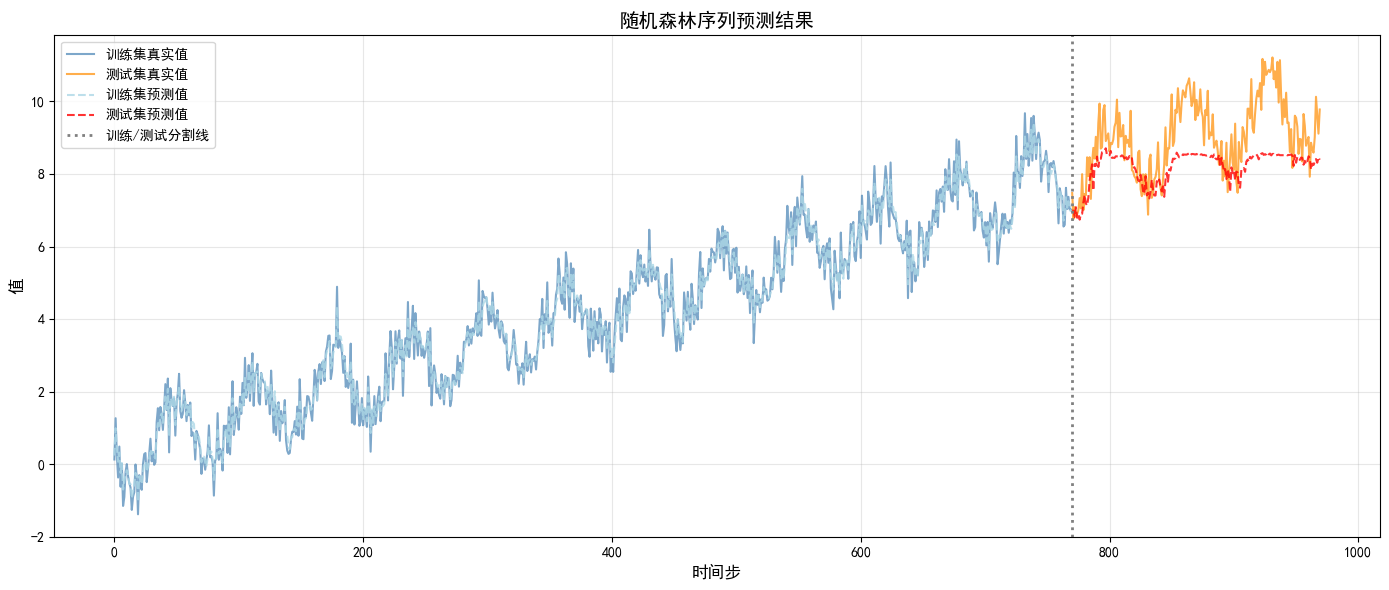

In [9]:
# ==================== 可视化预测结果 ====================
plt.figure(figsize=(14, 6))

# 绘制真实值
plt.plot(range(len(y_train_true)), y_train_true, 
         label='训练集真实值', color='steelblue', alpha=0.7)
plt.plot(range(len(y_train_true), len(y_train_true) + len(y_test_true)), y_test_true, 
         label='测试集真实值', color='darkorange', alpha=0.7)

# 绘制预测值
plt.plot(range(len(y_train_pred_inv)), y_train_pred_inv, 
         label='训练集预测值', color='lightblue', linestyle='--', alpha=0.8)
plt.plot(range(len(y_train_pred_inv), len(y_train_pred_inv) + len(y_test_pred_inv)), y_test_pred_inv, 
         label='测试集预测值', color='red', linestyle='--', alpha=0.8)

# 添加分割线
plt.axvline(x=len(y_train_true), color='gray', linestyle=':', linewidth=2, label='训练/测试分割线')

plt.title('随机森林序列预测结果', fontsize=14)
plt.xlabel('时间步', fontsize=12)
plt.ylabel('值', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 四、总结


1. **序列预测本质**：利用历史数据的时序关系预测未来值

2. **数据处理流程**：
   - 滑动窗口构建x-y对
   - 先滑动窗口，再划分数据集
   - 标准化时只用训练数据fit

3. **预测方式**：
   - 单步预测：一次预测一个时刻
   - 多步预测：递归式或直接式

4. **模型选择**：
   - 传统ML模型（如随机森林）可用于序列预测
   - 神经网络更适合复杂的多输入多输出任务

